In [43]:
import dadi

def split_mig_model(params, ns, pts):
    """
    Split model with initial isolation, followed by secondary contact and migration.
    
    params: List of parameters [nu_mainland, nu_island, T_split, T_mig, m]
    ns: List of sample sizes [n_mainland, n_island]
    pts: Number of grid points
    """
    nu_mainland, nu_island, T_split, T_mig, m = params
    
    # Create a grid of points
    xx = dadi.Numerics.default_grid(pts)
    
    # Ancestral population equilibrium
    phi = dadi.PhiManip.phi_1D(xx)
    
    # Split the population at time T_split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    
    # Integrate populations in isolation with sizes nu_mainland and nu_island for T_split - T_mig generations
    phi = dadi.Integration.two_pops(phi, xx, T_split - T_mig, nu_mainland, nu_island)
    
    # Integrate with migration from T_mig generations ago until present
    phi = dadi.Integration.two_pops(phi, xx, T_mig, nu_mainland, nu_island, m12=m, m21=m)
    
    # Calculate the frequency spectrum
    fs = dadi.Spectrum.from_phi(phi, ns, (xx, xx))
    
    return fs

def split_one_way_mig_model(params, ns, pts):
    """
    Split model with initial isolation, followed by secondary contact and 
    one-way migration from Mainland to Island.
    
    params: List of parameters [nu_mainland, nu_island, T_split, T_mig, m]
    ns: List of sample sizes [n_mainland, n_island]
    pts: Number of grid points
    """
    nu_mainland, nu_island, T_split, T_mig, m = params
    
    # Create a grid of points
    xx = dadi.Numerics.default_grid(pts)
    
    # Ancestral population equilibrium
    phi = dadi.PhiManip.phi_1D(xx)
    
    # Split the population at time T_split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    
    # Integrate populations in isolation with sizes nu_mainland and nu_island for T_split - T_mig generations
    phi = dadi.Integration.two_pops(phi, xx, T_split - T_mig, nu_mainland, nu_island)
    
    # Integrate with one-way migration from Mainland to Island from T_mig generations ago until present
    phi = dadi.Integration.two_pops(phi, xx, T_mig, nu_mainland, nu_island, m12=m, m21=0)
    
    # Calculate the frequency spectrum
    fs = dadi.Spectrum.from_phi(phi, ns, (xx, xx))
    
    return fs

def split_one_way_mig_model_flipped(params, ns, pts):
    """
    Split model with initial isolation, followed by secondary contact and 
    one-way migration from Island to Mainland.
    
    params: List of parameters [nu_mainland, nu_island, T_split, T_mig, m]
    ns: List of sample sizes [n_mainland, n_island]
    pts: Number of grid points
    """
    nu_mainland, nu_island, T_split, T_mig, m = params
    
    # Create a grid of points
    xx = dadi.Numerics.default_grid(pts)
    
    # Ancestral population equilibrium
    phi = dadi.PhiManip.phi_1D(xx)
    
    # Split the population at time T_split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    
    # Integrate populations in isolation with sizes nu_mainland and nu_island for T_split - T_mig generations
    phi = dadi.Integration.two_pops(phi, xx, T_split - T_mig, nu_mainland, nu_island)
    
    # Integrate with one-way migration from Island to Mainland from T_mig generations ago until present
    phi = dadi.Integration.two_pops(phi, xx, T_mig, nu_mainland, nu_island, m12=0, m21=m)
    
    # Calculate the frequency spectrum
    fs = dadi.Spectrum.from_phi(phi, ns, (xx, xx))
    
    return fs

In [3]:
# Import your VCF data and prepare SFS
vcf_file = '/nas/longleaf/home/adaigle/work/ghist_2024_work/target_vcfs/GHIST-secondary-contact.vcf'
popfile = '/nas/longleaf/home/adaigle/work/ghist_2024_work/target_vcfs/secondary-contact_popfile.txt'

# Step 1: Create a data dictionary from the VCF file
dd = dadi.Misc.make_data_dict_vcf(vcf_file, popfile)

# Step 2: Define population IDs and sample sizes
pop_ids = ['mainland', 'island']  # The populations to extract
ns = [22, 8]  # Sample sizes (down-project if needed to make fitting faster)

# Step 3: Generate the frequency spectrum (FS) from the data dictionary
fs = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)

In [44]:
from scipy.optimize import differential_evolution

# Define the sample sizes
ns = fs.sample_sizes

# Grid points for numerical integration
pts_l = [60, 70, 80]

# Initial parameter guesses: (nu_mainland, nu_island, T_split, T_mig, m)
p0 = [1.0, 1.0, 1, 0.005, 0.1]  # Ensure T_split > T_mig by a safe margin

# Bounds for parameters, adjusted to ensure T_split > T_mig
lower_bound = [0.1, 0.1, 0.1, 0.001, 0.0001]  # Set T_split's minimum to 0.1
upper_bound = [1000, 1000, 100, 0.09, 100]    # Set T_mig's maximum to less than T_split's minimum
# Generate the model SFS
func = dadi.Numerics.make_extrap_log_func(split_one_way_mig_model_flipped)

## Wrap optimization in try-except to capture and debug any errors that arise
#try:
#    # Optimize parameters
#    popt = dadi.Inference.optimize_log(
#        p0, fs, func, pts_l, lower_bound=lower_bound, upper_bound=upper_bound
#    )
#    print("Optimized parameters:", popt)
#except ValueError as e:
#    print("Error during optimization:", e)

# Define the bounds as a list of tuples for each parameter
#bounds = list(zip(lower_bound, upper_bound))
## Define an objective function that returns the negative log-likelihood
#def objective_func(params):
#    model = func(params, ns, pts_l)
#    return -dadi.Inference.ll_multinom(model, fs)
#
## Global optimization using differential evolution
#result = differential_evolution(objective_func, bounds, maxiter=500, popsize=20, disp=True)
#popt_global = result.x  # Parameters from the global search
#print("Parameters from global optimization:", popt_global)
#
#try:
#    # Refine with local optimization starting from global optimum
#    popt = dadi.Inference.optimize_log(
#        popt_global, fs, func, pts_l, lower_bound=lower_bound, upper_bound=upper_bound
#    )
#    print("Optimized parameters after refinement:", popt)
#except ValueError as e:
#    print("Error during optimization:", e)


initial_guesses = [
    [1.0, 1.0, 1, 0.005, 0.1],
    [2.0, 0.5, 0.5, 0.01, 0.05],
    [0.5, 2.0, 0.1, 0.02, 0.01],
    [1.5, 1.5, 0.2, 0.005, 0.02]
]

best_popt = None
best_ll = -float("inf")

for p0 in initial_guesses:
    try:
        popt = dadi.Inference.optimize_log(
            p0, fs, func, pts_l, lower_bound=lower_bound, upper_bound=upper_bound
        )
        model = func(popt, ns, pts_l)
        ll_model = dadi.Inference.ll_multinom(model, fs)
        if ll_model > best_ll:
            best_ll = ll_model
            best_popt = popt
        print(f"Log-likelihood for initial guess {p0}: {ll_model}")
    except ValueError as e:
        print("Error during optimization:", e)

print("Best parameters after multiple initializations:", best_popt)

popt=best_popt

Log-likelihood for initial guess [1.0, 1.0, 1, 0.005, 0.1]: -68920.8718583325
Log-likelihood for initial guess [2.0, 0.5, 0.5, 0.01, 0.05]: -13099.31667060377
Log-likelihood for initial guess [0.5, 2.0, 0.1, 0.02, 0.01]: -5892.586764762586
Log-likelihood for initial guess [1.5, 1.5, 0.2, 0.005, 0.02]: -39227.59132676431
Best parameters after multiple initializations: [2.84388542e+00 1.76368558e-01 1.44369717e-01 1.04639253e-03
 6.61811924e+01]


In [47]:
# Given parameters from your dadi analysis
# Mutation rate (per generation per base pair)
mu = 5.4e-9

# Size of genomic region sequenced (in base pairs)
L = 100_000_000

# Generation time (in years)
generation_time = 0.75

# Calculate theta from optimized model
model_fs = func(popt, ns, pts_l)
theta = dadi.Inference.optimal_sfs_scaling(model_fs, fs)
print(f"Real theta (θ): {theta:.5f}")

# Step 1: Calculate the ancestral population size (N_a)
N_a = theta / (4 * mu * L)

# Convert optimized values to actual population sizes and time estimates
nu_mainland, nu_island, T_split, T_mig, m = popt  # Optimized values
N_mainland = nu_mainland * N_a
N_island = nu_island * N_a

# Convert scaled time to actual time in generations
T_split_gen = T_split * 2 * N_a
T_mig_gen = T_mig * 2 * N_a

# Convert time in generations to time in years
T_split_years = T_split_gen * generation_time
T_mig_years = T_mig_gen * generation_time

# Scale migration rate to make it compatible with demes
# Use the harmonic mean of N_mainland and N_island for scaling
N_effective = 2 * (N_mainland * N_island) / (N_mainland + N_island)
m_scaled = m / N_effective

# Print the results
print(f"Ancestral population size (N_a): {N_a:.2f}")
print(f"Mainland population size (N_mainland): {N_mainland:.2f}")
print(f"Island population size (N_island): {N_island:.2f}")
print(f"Time of split in generations: {T_split_gen:.2f}")
print(f"Time of split in years: {T_split_years:.2f}")
print(f"Time of secondary contact in generations: {T_mig_gen:.2f}")
print(f"Time of secondary contact in years: {T_mig_years:.2f}")
print(f"Migration rate (m_scaled) for demes: {m_scaled:.9f}")


Real theta (θ): 133514.23257
Ancestral population size (N_a): 61812.14
Mainland population size (N_mainland): 175786.66
Island population size (N_island): 10901.72
Time of split in generations: 17847.60
Time of split in years: 13385.70
Time of secondary contact in generations: 129.36
Time of secondary contact in years: 97.02
Migration rate (m_scaled) for demes: 0.003223599


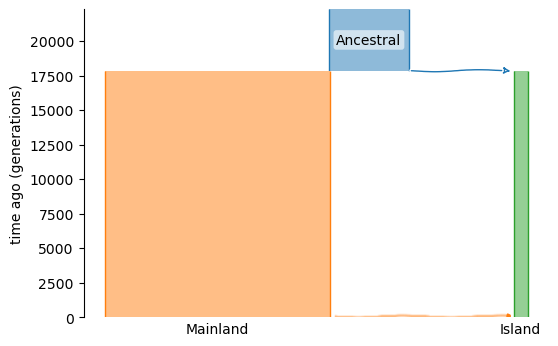

In [48]:
import matplotlib.pyplot as plt
import demes
import demesdraw

# Define the demographic model using a YAML string format, with one-way migration
yaml_model = f"""
description: Split with secondary contact and one-way migration
time_units: generations
demes:
  - name: Ancestral
    start_time: .inf
    epochs:
      - end_time: {T_split_gen:.2f}
        start_size: {N_a:.2f}

  - name: Mainland
    start_time: {T_split_gen:.2f}
    ancestors: [Ancestral]
    epochs:
      - end_time: {T_mig_gen:.2f}
        start_size: {N_mainland:.2f}
      - end_time: 0
        start_size: {N_mainland:.2f}

  - name: Island
    start_time: {T_split_gen:.2f}
    ancestors: [Ancestral]
    epochs:
      - end_time: {T_mig_gen:.2f}
        start_size: {N_island:.2f}
      - end_time: 0
        start_size: {N_island:.2f}

migrations:
  - source: Mainland
    dest: Island
    start_time: {T_mig_gen:.2f}
    end_time: 0
    rate: {m_scaled:.9f}  # Ensure m_scaled is within [0, 1]
"""

# Load the YAML model into a demes graph object
graph = demes.loads(yaml_model)

# Visualize the model
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
demesdraw.tubes(graph, ax=ax)
plt.show()


In [ ]:
import dadi
import matplotlib.pyplot as plt

# Assuming `fs` is your observed frequency spectrum from the real data
# Assuming `popt` are the optimized parameters from the inferred model

# 1. Generate the model frequency spectrum using the optimized parameters
# Your demographic model function should be already defined (e.g., split_no_mig_model)
model = func(popt, fs.sample_sizes, pts_l)

# 2. Plot the comparison between the observed and model frequency spectrum
fig = plt.figure(figsize=(12, 6))

# Use dadi's plotting function to compare the observed and model FS
dadi.Plotting.plot_2d_comp_multinom(model, fs, vmin=1, resid_range=3)

plt.show()

Log-likelihood of unidirectional model (Mainland to Island): -39203.91748350653
Log-likelihood of flipped unidirectional model (Island to Mainland): -39227.59132676431
Log-likelihood of bidirectional model: -39146.55994105151
LRT statistic: 114.71508491002896
p-value: 9.085711060055509e-27
The bidirectional migration model provides a significantly better fit.


In [51]:
from scipy.stats import chi2

# Define initial guesses for optimization
initial_guesses = [
    [1.0, 1.0, 1, 0.005, 0.1],
    [2.0, 0.5, 0.5, 0.01, 0.05],
    [0.5, 2.0, 0.1, 0.02, 0.01],
    [1.5, 1.5, 0.2, 0.005, 0.02]
]

# Function to find the best log-likelihood and parameters for a given model and initial guesses
def optimize_model(func, fs, ns, pts_l, initial_guesses, lower_bound, upper_bound):
    best_popt = None
    best_ll = -float("inf")
    
    for p0 in initial_guesses:
        try:
            popt = dadi.Inference.optimize_log(p0, fs, func, pts_l, lower_bound=lower_bound, upper_bound=upper_bound)
            model = func(popt, ns, pts_l)
            ll_model = dadi.Inference.ll_multinom(model, fs)
            if ll_model > best_ll:
                best_ll = ll_model
                best_popt = popt
            print(f"Log-likelihood for initial guess {p0}: {ll_model}")
        except ValueError as e:
            print("Error during optimization:", e)
    
    print("Best parameters after multiple initializations:", best_popt)
    return best_ll, best_popt

# Bounds for parameters, adjusted to ensure T_split > T_mig
lower_bound = [0.1, 0.1, 0.1, 0.001, 0.0001]
upper_bound = [1000, 1000, 100, 0.09, 100]

# Optimize the original unidirectional model (Mainland to Island)
func_uni = dadi.Numerics.make_extrap_log_func(split_one_way_mig_model)
best_ll_uni, best_popt_uni = optimize_model(func_uni, fs, ns, pts_l, initial_guesses, lower_bound, upper_bound)
print("Best log-likelihood of unidirectional model (Mainland to Island):", best_ll_uni)

# Optimize the flipped unidirectional model (Island to Mainland)
func_flipped = dadi.Numerics.make_extrap_log_func(split_one_way_mig_model_flipped)
best_ll_flipped, best_popt_flipped = optimize_model(func_flipped, fs, ns, pts_l, initial_guesses, lower_bound, upper_bound)
print("Best log-likelihood of flipped unidirectional model (Island to Mainland):", best_ll_flipped)

# Optimize the bidirectional model
func_bi = dadi.Numerics.make_extrap_log_func(split_mig_model)
best_ll_bi, best_popt_bi = optimize_model(func_bi, fs, ns, pts_l, initial_guesses, lower_bound, upper_bound)
print("Best log-likelihood of bidirectional model:", best_ll_bi)

# Compute the LRT statistic for bidirectional vs best unidirectional
best_lnL_uni = max(best_ll_uni, best_ll_flipped)
LRT = 2 * (best_ll_bi - best_lnL_uni)
p_value = chi2.sf(LRT, df=1)  # df=1 since the bidirectional model has 1 extra parameter (m21 or m12)

print(f"LRT statistic: {LRT}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The bidirectional migration model provides a significantly better fit.")
else:
    print("There is no significant difference; the unidirectional model may suffice.")


Log-likelihood for initial guess [1.0, 1.0, 1, 0.005, 0.1]: -67346.7864720498
Log-likelihood for initial guess [2.0, 0.5, 0.5, 0.01, 0.05]: -6961.288978511582
Log-likelihood for initial guess [0.5, 2.0, 0.1, 0.02, 0.01]: -16380.854627569908
Log-likelihood for initial guess [1.5, 1.5, 0.2, 0.005, 0.02]: -39203.91748350653
Best parameters after multiple initializations: [2.48359482e+00 2.63388049e-01 1.81658923e-01 1.07149259e-03
 5.26302169e+01]
Best log-likelihood of unidirectional model (Mainland to Island): -6961.288978511582
Log-likelihood for initial guess [1.0, 1.0, 1, 0.005, 0.1]: -68920.8718583325
Log-likelihood for initial guess [2.0, 0.5, 0.5, 0.01, 0.05]: -13099.31667060377
Log-likelihood for initial guess [0.5, 2.0, 0.1, 0.02, 0.01]: -5892.586764762586
Log-likelihood for initial guess [1.5, 1.5, 0.2, 0.005, 0.02]: -39227.59132676431
Best parameters after multiple initializations: [2.84388542e+00 1.76368558e-01 1.44369717e-01 1.04639253e-03
 6.61811924e+01]
Best log-likelihoo

In [52]:
import numpy as np
from scipy.stats import chi2

# Best parameter sets from previous optimization rounds
best_params_uni = [2.48359482, 0.26338805, 0.18165892, 0.00107149, 52.6302169]
best_params_flipped = [2.84388542, 0.17636856, 0.14436972, 0.00104639, 66.1811924]
best_params_bi = [2.39121498, 0.23048123, 0.21348559, 0.00105534, 58.8017396]

# Define a function to generate slightly perturbed parameters around the best ones
def generate_perturbed_params(base_params, perturb_factor=0.2, n=5):
    """
    Generate perturbed initial guesses around a base parameter set.
    
    Parameters:
    - base_params: The base parameter set to perturb
    - perturb_factor: The percentage by which to perturb each parameter
    - n: The number of perturbed sets to generate
    
    Returns:
    - List of perturbed parameter sets
    """
    perturbed_params = []
    for _ in range(n):
        perturbed = [param * (1 + np.random.uniform(-perturb_factor, perturb_factor)) for param in base_params]
        perturbed_params.append(perturbed)
    return perturbed_params

# Generate refined initial guesses based on each best parameter set
initial_guesses_uni = generate_perturbed_params(best_params_uni, perturb_factor=0.2, n=5)
initial_guesses_flipped = generate_perturbed_params(best_params_flipped, perturb_factor=0.2, n=5)
initial_guesses_bi = generate_perturbed_params(best_params_bi, perturb_factor=0.2, n=5)

# Combine all refined guesses for a comprehensive search
all_initial_guesses = initial_guesses_uni + initial_guesses_flipped + initial_guesses_bi

# Print the refined initial guesses for review
print("Refined initial guesses based on previous optimizations:")
for guess in all_initial_guesses:
    print(guess)

# Function to find the best log-likelihood and parameters for a given model and initial guesses
def optimize_model(func, fs, ns, pts_l, initial_guesses, lower_bound, upper_bound):
    best_popt = None
    best_ll = -float("inf")
    
    for p0 in initial_guesses:
        try:
            popt = dadi.Inference.optimize_log(p0, fs, func, pts_l, lower_bound=lower_bound, upper_bound=upper_bound)
            model = func(popt, ns, pts_l)
            ll_model = dadi.Inference.ll_multinom(model, fs)
            if ll_model > best_ll:
                best_ll = ll_model
                best_popt = popt
            print(f"Log-likelihood for initial guess {p0}: {ll_model}")
        except ValueError as e:
            print("Error during optimization:", e)
    
    print("Best parameters after multiple initializations:", best_popt)
    return best_ll, best_popt

# Bounds for parameters, adjusted to ensure T_split > T_mig
lower_bound = [0.1, 0.1, 0.1, 0.001, 0.0001]
upper_bound = [1000, 1000, 100, 0.09, 100]

# Optimize the original unidirectional model (Mainland to Island)
func_uni = dadi.Numerics.make_extrap_log_func(split_one_way_mig_model)
best_ll_uni, best_popt_uni = optimize_model(func_uni, fs, ns, pts_l, all_initial_guesses, lower_bound, upper_bound)
print("Best log-likelihood of unidirectional model (Mainland to Island):", best_ll_uni)

# Optimize the flipped unidirectional model (Island to Mainland)
func_flipped = dadi.Numerics.make_extrap_log_func(split_one_way_mig_model_flipped)
best_ll_flipped, best_popt_flipped = optimize_model(func_flipped, fs, ns, pts_l, all_initial_guesses, lower_bound, upper_bound)
print("Best log-likelihood of flipped unidirectional model (Island to Mainland):", best_ll_flipped)

# Optimize the bidirectional model
func_bi = dadi.Numerics.make_extrap_log_func(split_mig_model)
best_ll_bi, best_popt_bi = optimize_model(func_bi, fs, ns, pts_l, all_initial_guesses, lower_bound, upper_bound)
print("Best log-likelihood of bidirectional model:", best_ll_bi)

# Compute the LRT statistic for bidirectional vs best unidirectional
best_lnL_uni = max(best_ll_uni, best_ll_flipped)
LRT = 2 * (best_ll_bi - best_lnL_uni)
p_value = chi2.sf(LRT, df=1)  # df=1 since the bidirectional model has 1 extra parameter (m21 or m12)

print(f"LRT statistic: {LRT}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The bidirectional migration model provides a significantly better fit.")
else:
    print("There is no significant difference; the unidirectional model may suffice.")


Refined initial guesses based on previous optimizations:
[2.8238891919456233, 0.247066957189571, 0.1858966769086073, 0.00095722457135077, 62.29960163094748]
[2.5375859745806846, 0.23941436013909598, 0.20295340916532376, 0.0008620158851440095, 56.814460592008906]
[2.7620190135487386, 0.21666715600776432, 0.16146820225397257, 0.0011981979802929764, 57.002811197452644]
[2.600920435316296, 0.22764324708531808, 0.2066755155245153, 0.0009342537505066009, 59.242720623052776]
[2.1924748627147297, 0.2717151783522485, 0.2178040979172327, 0.0011416701546583465, 49.69015380760376]
[3.1746883520824545, 0.18968122123924475, 0.12177245368240854, 0.0011356649819567546, 75.45311185922304]
[3.02858743726538, 0.17972948726136614, 0.15051726979216898, 0.001114680260459011, 65.396939566109]
[2.8854106296544093, 0.18495374991003982, 0.16374671515022218, 0.0011782728874203613, 64.1290436982369]
[3.0218952869982885, 0.20519643272364932, 0.11841375477490373, 0.00098490692841054, 67.59228259721094]
[3.023136816

In [32]:
# Calculate AIC for unidirectional model
k_uni = len(popt_uni)  # Number of parameters in the unidirectional model
AIC_uni = 2 * k_uni - 2 * lnL_uni
print(f"AIC for unidirectional model: {AIC_uni}")

# Calculate AIC for bidirectional model
k_bi = len(popt_bi)  # Number of parameters in the bidirectional model
AIC_bi = 2 * k_bi - 2 * lnL_bi
print(f"AIC for bidirectional model: {AIC_bi}")

# Compare AIC values
if AIC_uni < AIC_bi:
    print("The unidirectional migration model is preferred based on AIC.")
else:
    print("The bidirectional migration model is preferred based on AIC.")


AIC for unidirectional model: 78417.83496701306
AIC for bidirectional model: 78303.11988210303
The bidirectional migration model is preferred based on AIC.
